In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [4]:
from helpers import load_data
from costs import *

# load dataset
x, y = load_data()

In [5]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [6]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train:   
    ytest= y[k_indices[k]]
    xtest= x[k_indices[k]]
    aux_xtrain= []
    aux_ytrain= []
    for i in range(len(k_indices)):
        if (i!= k):
            for j,z in enumerate (y[k_indices[i]]):
                aux_ytrain.append(z)
            for j,z in enumerate (x[k_indices[i]]):
                aux_xtrain.append(z)
    xtrain=np.zeros(len(aux_xtrain))
    ytrain=np.zeros(len(aux_ytrain))
    for i in range(len(aux_xtrain)):
        xtrain[i]=aux_xtrain[i]
        ytrain[i]=aux_ytrain[i]
        
    # ***************************************************
    # form data with polynomial degree
    xtrain=build_poly(xtrain,degree)
    xtest=build_poly(xtest,degree)
    # ***************************************************
    # ridge regression:
    rr_cost, w_ridge= ridge_regression(ytrain, xtrain, lambda_)
    # calculate the loss for train and test data:
    loss_tr= compute_mse(ytrain, xtrain, w_ridge)
    loss_te= compute_mse(ytest, xtest, w_ridge)
    
    return loss_tr, loss_te

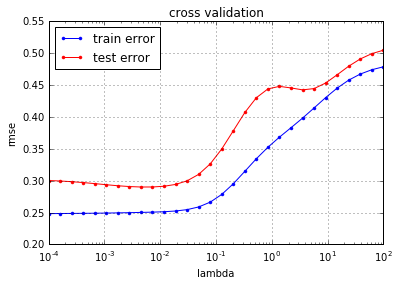

In [7]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for lambda_ in lambdas:
        tot_loss_tr=0
        tot_loss_te=0
        # cross validation: 
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            tot_loss_tr=tot_loss_tr+loss_tr
            tot_loss_te=tot_loss_te+loss_te
        tot_loss_tr=tot_loss_tr/k_fold
        tot_loss_te=tot_loss_te/k_fold
        rmse_tr.append(math.sqrt(2*tot_loss_tr))
        rmse_te.append(math.sqrt(2*tot_loss_te))
        
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

    
cross_validation_demo()

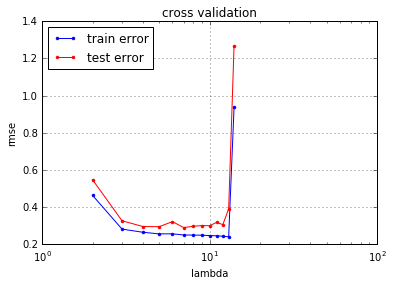

In [10]:
def cross_validation_demo2():
    #the idea is now to select the best degree, for a given lambda 
    # from the previous graph I suggest to choose lambda= 0.01
    seed = 1
    degrees = range(2,15)
    k_fold = 4
    lambda_ = 0.01
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for degree in degrees:
        tot_loss_tr=0
        tot_loss_te=0
        # cross validation: 
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            tot_loss_tr=tot_loss_tr+loss_tr
            tot_loss_te=tot_loss_te+loss_te
        tot_loss_tr=tot_loss_tr/k_fold
        tot_loss_te=tot_loss_te/k_fold
        rmse_tr.append(math.sqrt(2*tot_loss_tr))
        rmse_te.append(math.sqrt(2*tot_loss_te))
        
    # ***************************************************    
    cross_validation_visualization(degrees, rmse_tr, rmse_te)

    
cross_validation_demo2()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

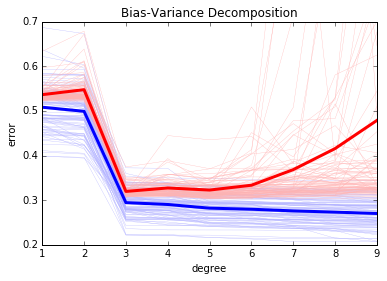

In [14]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # splitting the data according to the seed
        xtrain,xtest,ytrain,ytest=split_data(x, y,ratio_train,seed)
        # ***************************************************
        # bias_variance_decomposition: filling the matrices 
        for degree in degrees:
            #training the model and computing the training error
            mse_tr, w = least_squares(ytrain, build_poly(xtrain, degree))
            #computing the test error
            mse_te=compute_loss(ytest, build_poly(xtest, degree), w)
            #filling the matrices
            rmse_tr[index_seed, degree-1] = math.sqrt(2*mse_tr)
            rmse_te[index_seed, degree-1] = math.sqrt(2*mse_te)
        # ***************************************************
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()